# Разработка системы анализа медицинских изображений для эпидемиологического мониторинга COVID-19

Инфраструктура Big Data. Итоговый проект



### Цель проекта
Разработать аналитическую систему для эпидемиологического мониторинга COVID-19 на основе метаданных рентгеновских снимков, используя стек PySpark.

### Датасет
Используется репозиторий [COVID-19 Chest X-Ray Dataset](https://github.com/ieee8023/covid-chestxray-dataset/tree/master), который содержит:

Метаданные: файл metadata.csv с полями:

- `patientid` (идентификатор пациента)  
- `age` (возраст, есть не для всех записей)  
- `sex` (пол, не для всех записей)  
- `finding` (диагноз: COVID-19, Pneumonia, Normal и другие)  
- `view` (проекция снимка: PA, AP и так далее)  
- `date` (дата исследования)  

### 1. Подготовка среды

In [1]:
!java -version

openjdk version "17.0.16" 2025-07-15
OpenJDK Runtime Environment (build 17.0.16+8-Ubuntu-0ubuntu122.04.1)
OpenJDK 64-Bit Server VM (build 17.0.16+8-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)


In [2]:
!python --version

Python 3.12.12


In [ ]:
!pip install -r requirements.txt

In [3]:
# Установка PySpark
!pip install pyspark

In [40]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, mean, rand, trim, coalesce, to_date, max, lit, lower, year, udf
from pyspark.sql import Row
from pyspark.sql import Window
from pyspark.sql.types import StringType, IntegerType
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Убедимся, что Spark-сессия корректно запускается.
spark = SparkSession.builder.appName("CovidAnalyser").config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()
spark.version

'3.5.1'

In [6]:
spark.sparkContext

<SparkContext master=local[*] appName=CovidAnalyser>

In [8]:
df = spark.read.csv("metadata.csv", header=True, inferSchema=True)

In [9]:
# Проверим работу базовых операций с данными.
df.printSchema()

root
 |-- patientid: string (nullable = true)
 |-- offset: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pO2_saturation: double (nullable = true)
 |-- leukocyte_count: double (nullable = true)
 |-- neutrophil_count: double (nullable = true)
 |-- lymphocyte_count: double (nullable = true)
 |-- view: string (nullable = true)
 |-- modality: string (nullable = true)
 |-- date: string (nullable = true)
 |-- location: string (nullable = true)
 |-- folder: string (nullable = true)
 |-- filename: string (nullable 

In [10]:
df.describe().show()

+-------+------------------+------------------+----+------------------+----------+---------------+--------+---------+------------------+--------+------+----------------------+---------+------------------+-----------------+------------------+------------------+------------------+----+--------+------------------+------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|         patientid|            offset| sex|               age|   finding|RT_PCR_positive|survival|intubated|intubation_present|went_icu|in_icu|needed_supplemental_O2|extubated|       temperature|   pO2_saturation|   leukocyte_count|  neutrophil_count|  lymphocyte_count|view|modality|              date|          location| folder|            filename|                 doi|                 url|             license|      clinical_notes|         other_notes|                _c29|
+-------+-----------------

In [11]:
df.select("patientid", "age", "sex", "finding", "view", "date").show()

+---------+----+----+--------------------+----+----------------+
|patientid| age| sex|             finding|view|            date|
+---------+----+----+--------------------+----+----------------+
|        2|  65|   M|Pneumonia/Viral/C...|  PA|January 22, 2020|
|        2|  65|   M|Pneumonia/Viral/C...|  PA|January 25, 2020|
|        2|  65|   M|Pneumonia/Viral/C...|  PA|January 27, 2020|
|        2|  65|   M|Pneumonia/Viral/C...|  PA|January 28, 2020|
|        4|  52|   F|Pneumonia/Viral/C...|  PA|January 25, 2020|
|        4|  52|   F|Pneumonia/Viral/C...|  PA|January 30, 2020|
|        5|NULL|NULL|           Pneumonia|  PA|            2017|
|        6|NULL|NULL|Pneumonia/Viral/C...|  PA| January 6, 2020|
|        6|NULL|NULL|Pneumonia/Viral/C...|  PA|January 10, 2020|
|        3|  74|   M|Pneumonia/Viral/SARS|  AP|            2004|
|        3|  74|   M|Pneumonia/Viral/SARS|  AP|            2004|
|        3|  74|   M|Pneumonia/Viral/SARS|  AP|            2004|
|        7|  29|   F|Pneu

In [12]:
df.filter(col("age") > 18).show()

+---------+------+---+---+--------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+----------------+----------------+----+--------+----------------+--------------------+------+--------------------+--------------------+--------------------+-------+--------------------+-----------+----+
|patientid|offset|sex|age|             finding|RT_PCR_positive|survival|intubated|intubation_present|went_icu|in_icu|needed_supplemental_O2|extubated|temperature|pO2_saturation|leukocyte_count|neutrophil_count|lymphocyte_count|view|modality|            date|            location|folder|            filename|                 doi|                 url|license|      clinical_notes|other_notes|_c29|
+---------+------+---+---+--------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+---------------

In [13]:
df.filter(col("age") > 85).show()

+---------+------+---+---+--------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+----------------+----------------+---------+--------+-------------+--------------------+------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+----+
|patientid|offset|sex|age|             finding|RT_PCR_positive|survival|intubated|intubation_present|went_icu|in_icu|needed_supplemental_O2|extubated|temperature|pO2_saturation|leukocyte_count|neutrophil_count|lymphocyte_count|     view|modality|         date|            location|folder|            filename|                 doi|                 url|    license|      clinical_notes|         other_notes|_c29|
+---------+------+---+---+--------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+-

In [14]:
df.groupBy("sex").agg({"age":"avg"}).show()

+----+------------------+
| sex|          avg(age)|
+----+------------------+
|   F|54.846456692913385|
|NULL|              52.0|
|   M| 52.85091743119266|
+----+------------------+



### 2. Предобработка данных

In [15]:
# Создадим копию датасета для работы с нужными по заданию колонками
patients = df.select("patientid", "age", "sex", "finding", "view", "date")
patients.printSchema()

root
 |-- patientid: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- finding: string (nullable = true)
 |-- view: string (nullable = true)
 |-- date: string (nullable = true)



Очистка метаданных

In [16]:
# Ищем и заполняем пропуски в данных
missing_data_counts = patients.select([
    count(when(col(c).isNull(), c)).alias(c) for c in patients.columns
])

missing_data_counts.show()

+---------+---+---+-------+----+----+
|patientid|age|sex|finding|view|date|
+---------+---+---+-------+----+----+
|        0|237| 80|      0|   0| 289|
+---------+---+---+-------+----+----+



patientid: 0 пропусков

age: 237 пропусков

sex: 80 пропусков

finding: 0 пропусков

view: 0 пропусков

date: 289 пропусков

In [17]:
print(f"Всего строк в наборе данных: {patients.count()}")

Всего строк в наборе данных: 950


In [18]:
total_count = patients.count()
for row in missing_data_counts.collect():
    for col_name in patients.columns:
        null_count = row[col_name]
        if null_count != 0:
            print(f"'{col_name}': {null_count} пропусков ({null_count/total_count*100:.2f}%)")

'age': 237 пропусков (24.95%)
'sex': 80 пропусков (8.42%)
'date': 289 пропусков (30.42%)


In [19]:
# Заполняем пропуски в данных.
# age - заполним средним
mean_age = patients.select(mean(col("age")).cast("int")).collect()[0][0]
print(f'Средний возраст: {mean_age}')

patients_filled = patients.fillna({"age": mean_age})
print(f"Заполнено {missing_data_counts.select('age').collect()[0][0]} пропусков в 'age' значением {mean_age}")

Средний возраст: 53
Заполнено 237 пропусков в 'age' значением 53


sex - категориальный признак. перед заполнением пропусков необходимо посмотреть категории

In [20]:
sex_unique_vals = patients.select("sex").distinct().rdd.flatMap(lambda x: x).collect()
print(f'Категории значений пола: {len(sex_unique_vals)}: {sex_unique_vals}')

Категории значений пола: 3: ['F', 'M', None]


In [21]:
patients.groupBy("sex").count().show()

+----+-----+
| sex|count|
+----+-----+
|   F|  311|
|NULL|   80|
|   M|  559|
+----+-----+



In [22]:
# sex - заполним пропорционально существующему распределению
count_F = patients.filter(col("sex") == 'F').count()
count_M = patients.filter(col("sex") == 'M').count()

# Вычисляем вероятность
prob_f = count_F / (count_F + count_M)  # 311 / (311 + 559) = ~0.357

# Заполняем
patients_filled = patients_filled.withColumn(
    "sex",
    when(
        col("sex").isNull(),
        when(rand() < prob_f, "F").otherwise("M")
    ).otherwise(col("sex"))
)

print(f"Заполнено {missing_data_counts.select('sex').collect()[0][0]} пропусков в 'sex'")
patients_filled.groupBy("sex").count().show()

Заполнено 80 пропусков в 'sex'
+---+-----+
|sex|count|
+---+-----+
|  F|  339|
|  M|  611|
+---+-----+



date - признак даты, должен иметь правильный тип данных DateType

In [23]:
# преобразуем в единый формат
patients_filled = patients_filled.withColumn(
    "date_str",
    trim("date")   # убираем пробелы и невидимые символы
).withColumn(
    "date",
    coalesce(
        to_date("date", "MMMM d, yyyy"),
        to_date("date", "MMMM dd, yyyy"),
        to_date("date", "MMM d, yyyy"),
        to_date("date", "MMM dd, yyyy"),
        to_date("date", "yyyy")
    )
).drop("date_str")

In [24]:
# date - заполним максимальной датой среди уже имеющихся
max_date = patients_filled.select(max("date")).first()[0]
print(f'Максимальная дата: {max_date}')

# Заполняем пропуски в дате максимальной датой
patients_filled = patients_filled.withColumn(
    "date",
    coalesce(
        col("date"),
        lit(max_date).cast("date")
    )
)
print(f"Заполнено {missing_data_counts.select('date').collect()[0][0]} пропусков в 'date' значением {max_date}")

Максимальная дата: 2020-04-06
Заполнено 289 пропусков в 'date' значением 2020-04-06


In [25]:
# проверяем, что пропуски заполнены
patients_filled.select([
    count(when(col(c).isNull(), c)).alias(c) for c in patients.columns
]).show()

+---------+---+---+-------+----+----+
|patientid|age|sex|finding|view|date|
+---------+---+---+-------+----+----+
|        0|  0|  0|      0|   0|   0|
+---------+---+---+-------+----+----+



finding - категориальный признак  
Посмотрим, какие еать категории

In [26]:
finding_unique_vals = patients.select("finding").distinct().rdd.flatMap(lambda x: x).collect()
print(f'Категории значений диагноза: {len(finding_unique_vals)}:')
for i, val in enumerate(finding_unique_vals, 1):
    print(f" {val}")

Категории значений диагноза: 25:
 Pneumonia/Bacterial/Streptococcus
 Pneumonia/Aspiration
 Pneumonia/Lipoid
 Tuberculosis
 Pneumonia/Fungal/Pneumocystis
 Pneumonia/Bacterial/Klebsiella
 Pneumonia/Bacterial
 Pneumonia/Viral/MERS-CoV
 Unknown
 Pneumonia/Viral/Varicella
 Pneumonia/Bacterial/Staphylococcus/MRSA
 Pneumonia/Viral/Influenza/H1N1
 Pneumonia/Bacterial/Nocardia
 todo
 Pneumonia/Bacterial/Mycoplasma
 Pneumonia/Viral/Influenza
 Pneumonia/Viral/COVID-19
 Pneumonia/Viral/SARS
 Pneumonia/Bacterial/Legionella
 Pneumonia/Fungal/Aspergillosis
 Pneumonia/Viral/Herpes 
 No Finding
 Pneumonia/Bacterial/E.Coli
 Pneumonia
 Pneumonia/Bacterial/Chlamydophila


In [27]:
# Унифицируем диагнозы.
patients_filled = patients_filled.withColumn(
    "finding_uni", lower(trim("finding"))
).withColumn(
    "finding",
    when(col("finding_uni") == "tuberculosis", "tuberculosis")
    .when(col("finding_uni") == "no finding", "no_finding")
    .when(col("finding_uni").isin("unknown", "todo"), "unknown")
    .when(col("finding_uni").like("pneumonia/bacterial%"), "pneumonia_bacterial")
    .when(col("finding_uni") == "pneumonia/viral/covid-19", "covid19")
    .when(col("finding_uni").like("pneumonia/viral/%"), "pneumonia_viral_other")
    .when(col("finding_uni").like("pneumonia/fungal%"), "pneumonia_fungal")
    .when(col("finding_uni").isin("pneumonia/aspiration", "pneumonia/lipoid", "pneumonia"), "pneumonia_other")
    .otherwise("other")
).drop("finding_uni")

In [28]:
# Удалим дубликаты.
patients_filled = patients_filled.dropDuplicates()

In [29]:
patients_filled.show()

+---------+---+---+-------------------+---------+----------+
|patientid|age|sex|            finding|     view|      date|
+---------+---+---+-------------------+---------+----------+
|       16| 59|  F|            covid19|       PA|2020-01-01|
|       89| 75|  M|pneumonia_bacterial|       PA|2018-01-01|
|      221| 53|  M|            covid19|AP Supine|2020-01-01|
|     361b| 60|  M|    pneumonia_other|        L|2020-04-06|
|      383| 35|  F|    pneumonia_other|        L|2020-04-06|
|      105| 53|  M|   pneumonia_fungal|        L|2010-01-01|
|      141| 65|  M|            covid19|       PA|2020-01-01|
|      165| 53|  F|            covid19|       AP|2020-04-06|
|      315| 78|  F|         no_finding|       PA|2020-03-04|
|      294| 72|  M|            covid19|       AP|2020-01-01|
|       32| 43|  M|            covid19|       AP|2020-03-10|
|       76| 40|  F|            covid19|       PA|2020-01-01|
|      201| 77|  M|            covid19|AP Supine|2020-04-06|
|       77| 65|  F|     

### 3. Анализ качества данных

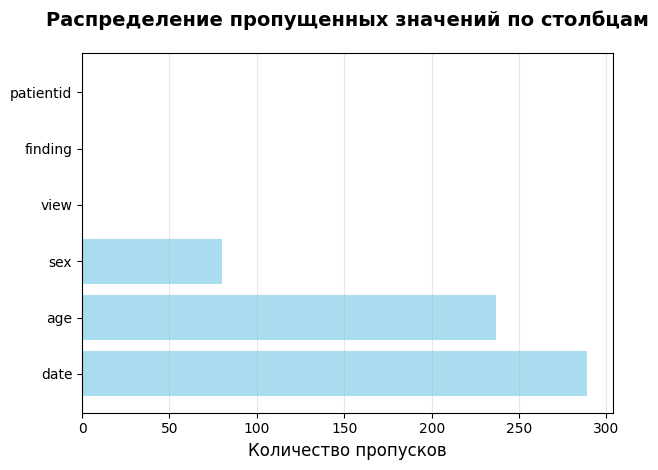

In [30]:
# Построим распределение пропущенных значений по всем полям.
missing_data_counts = patients.select([
    count(when(col(c).isNull(), c)).alias(c) for c in patients.columns
])

# Преобразуем в pandas для визуализации
missing_df = missing_data_counts.toPandas().transpose()
missing_df.columns = ['missing_count']
total_rows = patients.count()
missing_df['percentage'] = (missing_df['missing_count'] / total_rows) * 100
missing_df = missing_df.sort_values('missing_count', ascending=True)

# график
bars = plt.barh(missing_df.index, missing_df['missing_count'], color='skyblue', alpha=0.7)
plt.gca().invert_yaxis()  # Инвертируем ось Y для сортировки сверху вниз

plt.xlabel('Количество пропусков', fontsize=12)
plt.title('Распределение пропущенных значений по столбцам', fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

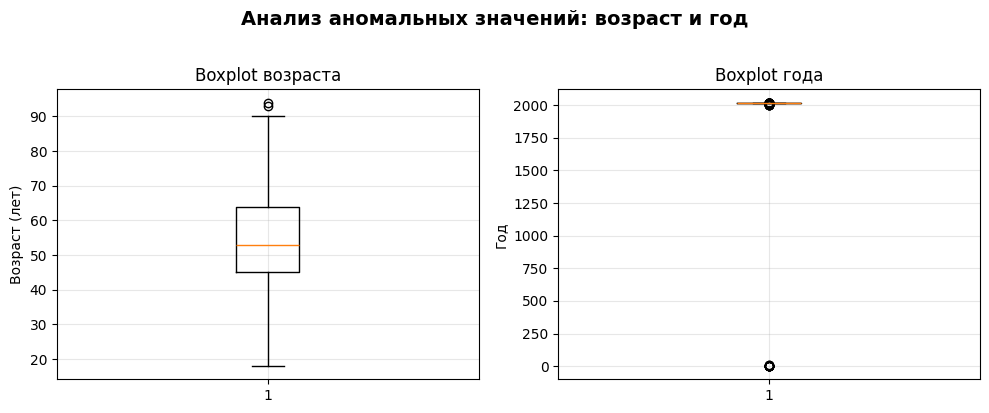

In [31]:
# Выявим аномальные значения
#  скорее всего могут быть в age, date

# Подготовка данных для age
age_df = patients_filled.select("age").where(col("age").isNotNull()).toPandas()

# Подготовка данных для года
year_pdf = (
    patients_filled
    .select(year("date").alias("year"))
    .toPandas()
)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].boxplot(age_df["age"])
axes[0].set_title("Boxplot возраста", fontsize=12)
axes[0].set_ylabel("Возраст (лет)", fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(year_pdf["year"].dropna())
axes[1].set_title("Boxplot года", fontsize=12)
axes[1].set_ylabel("Год", fontsize=10)
axes[1].grid(True, alpha=0.3)

fig.suptitle('Анализ аномальных значений: возраст и год',
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

In [32]:
# Обработаем аномальные значения

# Возраст
patients_filled.filter(patients['age'] > 90).show()

+---------+---+---+-------+----+----------+
|patientid|age|sex|finding|view|      date|
+---------+---+---+-------+----+----------+
|     324b| 93|  F|covid19|  AP|2020-01-01|
|     326b| 94|  M|covid19|  AP|2020-01-01|
+---------+---+---+-------+----+----------+



Всего два отличающихся от общей массы значения - 93 и 94 лет. Такие случаи могут быть вполне реальны, и не являются ошибкой при заполнении или аномальным выбросом. Эти значения оставляем

In [33]:
# Дата (год)
patients_filled = patients_filled.filter(
    year(col("date")) >= 2000
)

Задокументируем обнаруженные проблемы данных.

- наличие пропущенных значений в столбцах `sex`, `age`, `date` (они обработаны и заполнены в patients_filled);

- наличие аномального значения в столбце `date`- 0. Такое значение это выброс, удаляем.

### 4. SQL-аналитика

In [34]:
patients_filled.createOrReplaceTempView("patients")

In [35]:
# Запрос 1. Базовая статистика по диагнозам.
spark.sql("""
    WITH diagnosis_stats AS (
        SELECT
            finding AS diagnosis,
            COUNT(*) AS total_count,
            AVG(age) AS avg_age,
            MIN(age) AS min_age,
            MAX(age) AS max_age
        FROM patients
        GROUP BY finding
    )
    SELECT
        diagnosis,
        total_count,
        ROUND(avg_age, 2) AS avg_age,
        min_age,
        max_age
    FROM diagnosis_stats
    ORDER BY total_count DESC;
""").show()

+--------------------+-----------+-------+-------+-------+
|           diagnosis|total_count|avg_age|min_age|max_age|
+--------------------+-----------+-------+-------+-------+
|             covid19|        433|  55.44|     20|     94|
|     pneumonia_other|         69|  53.72|     18|     90|
| pneumonia_bacterial|         40|  50.15|     25|     80|
|pneumonia_viral_o...|         30|   48.6|     23|     76|
|             unknown|         28|   53.0|     53|     53|
|    pneumonia_fungal|         26|  40.38|     21|     70|
|          no_finding|         19|  52.11|     22|     78|
|        tuberculosis|         17|  42.29|     20|     78|
+--------------------+-----------+-------+-------+-------+



In [36]:
# Запрос 2. Распределение по полу и диагнозам.
spark.sql("""
    SELECT
        finding AS diagnosis,
        sex,
        COUNT(*) AS count
    FROM patients
    GROUP BY finding, sex
    ORDER BY diagnosis, sex
""").show()

+--------------------+---+-----+
|           diagnosis|sex|count|
+--------------------+---+-----+
|             covid19|  F|  149|
|             covid19|  M|  284|
|          no_finding|  F|    8|
|          no_finding|  M|   11|
| pneumonia_bacterial|  F|   14|
| pneumonia_bacterial|  M|   26|
|    pneumonia_fungal|  F|    2|
|    pneumonia_fungal|  M|   24|
|     pneumonia_other|  F|   33|
|     pneumonia_other|  M|   36|
|pneumonia_viral_o...|  F|   13|
|pneumonia_viral_o...|  M|   17|
|        tuberculosis|  F|    5|
|        tuberculosis|  M|   12|
|             unknown|  F|    6|
|             unknown|  M|   22|
+--------------------+---+-----+



In [37]:
# Запрос 3. Оконная функция (топ-3 по возрасту в каждой группе диагнозов).
spark.sql("""
    WITH ranked_patients AS (
        SELECT
            patientid,
            age,
            sex,
            finding AS diagnosis,
            date,
            ROW_NUMBER() OVER (PARTITION BY finding ORDER BY age DESC) AS age_rank
        FROM patients
    ),
    top_3_by_diagnosis AS (
        SELECT
            patientid,
            age,
            sex,
            diagnosis,
            date,
            age_rank
        FROM ranked_patients
        WHERE age_rank <= 3
    )
    SELECT *
    FROM top_3_by_diagnosis
    ORDER BY diagnosis, age_rank;
""").show(truncate=False)

+---------+---+---+---------------------+----------+--------+
|patientid|age|sex|diagnosis            |date      |age_rank|
+---------+---+---+---------------------+----------+--------+
|326b     |94 |M  |covid19              |2020-01-01|1       |
|324b     |93 |F  |covid19              |2020-01-01|2       |
|200      |88 |M  |covid19              |2020-04-06|3       |
|315      |78 |F  |no_finding           |2020-03-04|1       |
|313b     |75 |M  |no_finding           |2020-01-01|2       |
|478      |75 |F  |no_finding           |2020-04-06|3       |
|91       |80 |F  |pneumonia_bacterial  |2018-01-01|1       |
|340      |80 |M  |pneumonia_bacterial  |2013-01-01|2       |
|340      |80 |M  |pneumonia_bacterial  |2013-01-01|3       |
|109      |70 |M  |pneumonia_fungal     |2015-01-01|1       |
|109      |70 |M  |pneumonia_fungal     |2015-01-01|2       |
|105      |53 |M  |pneumonia_fungal     |2010-01-01|3       |
|460      |90 |M  |pneumonia_other      |2020-04-06|1       |
|460    

In [38]:
# Запрос 4. Анализ временных трендов по датам исследований.
spark.sql("""
    WITH yearly_trends AS (
        SELECT
            YEAR(date) AS year,
            finding AS diagnosis,
            COUNT(*) AS studies_count,
            ROUND(AVG(age)) AS avg_age,
            COUNT(CASE WHEN age IS NOT NULL THEN 1 END) AS age_count
        FROM patients
        GROUP BY YEAR(date), finding
    )
    SELECT
        year,
        diagnosis,
        studies_count,
        avg_age,
        ROUND(studies_count * 100.0 / SUM(studies_count) OVER(PARTITION BY year), 2) AS yearly_percentage
    FROM yearly_trends
    ORDER BY year DESC, studies_count DESC;
""").show()

+----+--------------------+-------------+-------+-----------------+
|year|           diagnosis|studies_count|avg_age|yearly_percentage|
+----+--------------------+-------------+-------+-----------------+
|2020|             covid19|          429|   55.0|            72.47|
|2020|     pneumonia_other|           57|   52.0|             9.63|
|2020|             unknown|           28|   53.0|             4.73|
|2020|pneumonia_viral_o...|           20|   50.0|             3.38|
|2020|          no_finding|           17|   51.0|             2.87|
|2020|        tuberculosis|           17|   42.0|             2.87|
|2020| pneumonia_bacterial|           16|   44.0|             2.70|
|2020|    pneumonia_fungal|            8|   30.0|             1.35|
|2019|             covid19|            4|   53.0|            50.00|
|2019|          no_finding|            2|   61.0|            25.00|
|2019| pneumonia_bacterial|            1|   65.0|            12.50|
|2019|     pneumonia_other|            1|   50.0

In [39]:
# Запрос 5. Статистика по проекциям снимков и их связи с диагнозами.
spark.sql("""
    SELECT
        view AS projection,
        finding AS diagnosis,
        COUNT(*) AS count
    FROM patients
    GROUP BY view, finding
    ORDER BY projection, count DESC
""").show(truncate=False)

+----------+---------------------+-----+
|projection|diagnosis            |count|
+----------+---------------------+-----+
|AP        |covid19              |106  |
|AP        |pneumonia_other      |14   |
|AP        |pneumonia_viral_other|11   |
|AP        |pneumonia_bacterial  |9    |
|AP        |no_finding           |4    |
|AP        |tuberculosis         |2    |
|AP        |pneumonia_fungal     |1    |
|AP Erect  |pneumonia_bacterial  |1    |
|AP Supine |covid19              |92   |
|AP Supine |unknown              |18   |
|AP Supine |pneumonia_other      |8    |
|AP Supine |pneumonia_fungal     |3    |
|AP Supine |pneumonia_bacterial  |2    |
|AP Supine |pneumonia_viral_other|2    |
|AP Supine |no_finding           |2    |
|Axial     |covid19              |44   |
|Axial     |no_finding           |3    |
|Coronal   |covid19              |13   |
|L         |covid19              |24   |
|L         |pneumonia_other      |19   |
+----------+---------------------+-----+
only showing top

### 5. Обработка в PySpark

In [42]:
# Использование UDF:

# Реализация пользовательской функции для категоризации возраста.
def get_age_category(age):
    if age is None:
        return "not specified"

    if age < 0:
        return "invalid age value"

    elif age <= 12:
        return "child (0-12)"
    elif age <= 19:
        return "teenager (13-19)"
    elif age <= 30:
        return "young adult (20-29)"
    elif age <= 60:
        return "adult (20-60)"
    else:
        return "senior (> 60)"

age_udf = udf(get_age_category, StringType())
df_proc = patients_filled.withColumn("age_group", age_udf(col("age")))
df_proc.select("patientid", "age", "age_group").show()

+---------+---+-------------+
|patientid|age|    age_group|
+---------+---+-------------+
|       16| 59|adult (20-60)|
|       89| 75|senior (> 60)|
|      221| 53|adult (20-60)|
|     361b| 60|adult (20-60)|
|      383| 35|adult (20-60)|
|      105| 53|adult (20-60)|
|      141| 65|senior (> 60)|
|      165| 53|adult (20-60)|
|      315| 78|senior (> 60)|
|      294| 72|senior (> 60)|
|       32| 43|adult (20-60)|
|       76| 40|adult (20-60)|
|      201| 77|senior (> 60)|
|       77| 65|senior (> 60)|
|      289| 53|adult (20-60)|
|      344| 78|senior (> 60)|
|      404| 34|adult (20-60)|
|     426b| 70|senior (> 60)|
|      205| 55|adult (20-60)|
|       17| 54|adult (20-60)|
+---------+---+-------------+
only showing top 20 rows



In [53]:
# Унификация диагнозов
diagnosises_map = {
    "no finding": "no_finding",
    "unknown": "unknown",
    "todo": "unknown",
    "tuberculosis": "tuberculosis",
    "pneumonia/viral/covid-19": "covid19",
    "pneumonia/viral/sars": "sars",
    "pneumonia/viral/mers-cov": "mers",
}

def unify_diagnosis(raw: str) -> str:
    if raw is None:
        return "unknown"
    s = raw.strip().lower()
    if s in diagnosises_map:
        return diagnosises_map[s]
    if s.startswith("pneumonia/bacterial"):
        return "pneumonia_bacterial"
    if s.startswith("pneumonia/viral/"):
        return "pneumonia_viral_other"
    if s.startswith("pneumonia/fungal"):
        return "pneumonia_fungal"
    if s.startswith("pneumonia"):
        return "pneumonia"
    return "other"

diagnosis_udf = udf(unify_diagnosis, StringType())
df_proc = df_proc.withColumn("finding_unified", diagnosis_udf(col("finding")))
df_proc.select("patientid","finding", "finding_unified").distinct().show(20, truncate=False)

+---------+----------------+---------------+
|patientid|finding         |finding_unified|
+---------+----------------+---------------+
|131      |covid19         |other          |
|237      |covid19         |other          |
|314      |covid19         |other          |
|95       |covid19         |other          |
|106      |pneumonia_fungal|pneumonia      |
|208      |covid19         |other          |
|425d     |unknown         |unknown        |
|431      |unknown         |unknown        |
|444      |unknown         |unknown        |
|60       |covid19         |other          |
|113      |covid19         |other          |
|185      |covid19         |other          |
|411      |pneumonia_fungal|pneumonia      |
|227      |covid19         |other          |
|256      |covid19         |other          |
|197      |covid19         |other          |
|302      |covid19         |other          |
|447      |covid19         |other          |
|168      |covid19         |other          |
|413      

In [81]:
# Унификация диагнозов
diagnosises_map = {
    "no finding": "no_finding",
    "unknown": "unknown",
    "todo": "unknown",
    "tuberculosis": "tuberculosis",
    "covid19": "covid19",
    "pneumonia/viral/sars": "sars",
    "pneumonia/viral/mers-cov": "mers",
}

def unify_diagnosis(raw: str) -> str:
    if raw is None:
        return "unknown"
    s = raw.strip().lower()
    if s in diagnosises_map:
        return diagnosises_map[s]
    if s.startswith("pneumonia/bacterial"):
        return "pneumonia_bacterial"
    if s.startswith("pneumonia/viral/"):
        return "pneumonia_viral_other"
    if s.startswith("pneumonia/fungal"):
        return "pneumonia_fungal"
    if s.startswith("pneumonia"):
        return "pneumonia"
    return "other"

diagnosis_udf = udf(unify_diagnosis, StringType())
df_proc = df_proc.withColumn("finding_unified", diagnosis_udf(col("finding")))
df_proc.select("patientid","finding", "finding_unified").distinct().show(20, truncate=False)

+---------+----------------+---------------+
|patientid|finding         |finding_unified|
+---------+----------------+---------------+
|270      |covid19         |covid19        |
|313b     |covid19         |covid19        |
|106      |pneumonia_fungal|pneumonia      |
|225      |covid19         |covid19        |
|233      |covid19         |covid19        |
|68       |covid19         |covid19        |
|177      |covid19         |covid19        |
|425d     |unknown         |unknown        |
|431      |unknown         |unknown        |
|444      |unknown         |unknown        |
|459      |covid19         |covid19        |
|48       |covid19         |covid19        |
|124      |covid19         |covid19        |
|411      |pneumonia_fungal|pneumonia      |
|128      |covid19         |covid19        |
|72       |covid19         |covid19        |
|43       |covid19         |covid19        |
|139      |covid19         |covid19        |
|352      |covid19         |covid19        |
|413      

In [54]:
# фильтрация данных по заданным критериям.

# Отфильтруем пациентов подростков, у которых нашли патологические изменения
patients_filtered = df_proc.filter(
    (col("age_group") == "teenager (12-19)") &
    (col("finding_unified") != "no_finding")
)

patients_filtered.select("patientid", "age", "age_group", "sex", "finding_unified", "view", "date").show(10)
print("Число строк после фильтрации:", patients_filtered.count())

+---------+---+----------------+---+---------------+----+----------+
|patientid|age|       age_group|sex|finding_unified|view|      date|
+---------+---+----------------+---+---------------+----+----------+
|      451| 18|teenager (12-19)|  M|      pneumonia|  PA|2020-04-06|
+---------+---+----------------+---+---------------+----+----------+

Число строк после фильтрации: 1


In [55]:
# или например лица, старше 50, с наличием патологий
patients_filtered = df_proc.filter(
    (col("age") >= 50) &
    (col("finding_unified") != "no_finding")
)

patients_filtered.select("patientid", "age", "age_group", "sex", "finding_unified", "view", "date").show(10)
print("Число строк после фильтрации:", patients_filtered.count())

+---------+---+-------------+---+---------------+---------+----------+
|patientid|age|    age_group|sex|finding_unified|     view|      date|
+---------+---+-------------+---+---------------+---------+----------+
|       16| 59|adult (20-60)|  F|          other|       PA|2020-01-01|
|       89| 75|senior (> 60)|  M|      pneumonia|       PA|2018-01-01|
|      221| 53|adult (20-60)|  M|          other|AP Supine|2020-01-01|
|     361b| 60|adult (20-60)|  M|      pneumonia|        L|2020-04-06|
|      105| 53|adult (20-60)|  M|      pneumonia|        L|2010-01-01|
|      141| 65|senior (> 60)|  M|          other|       PA|2020-01-01|
|      165| 53|adult (20-60)|  F|          other|       AP|2020-04-06|
|      315| 78|senior (> 60)|  F|          other|       PA|2020-03-04|
|      294| 72|senior (> 60)|  M|          other|       AP|2020-01-01|
|      201| 77|senior (> 60)|  M|          other|AP Supine|2020-04-06|
+---------+---+-------------+---+---------------+---------+----------+
only s

In [56]:
# сохранение в оптимизированом формате Parquet
path = "/content/covid19.parquet"

patients_filtered.write.mode("overwrite").parquet(path)

### 6. Визуализация

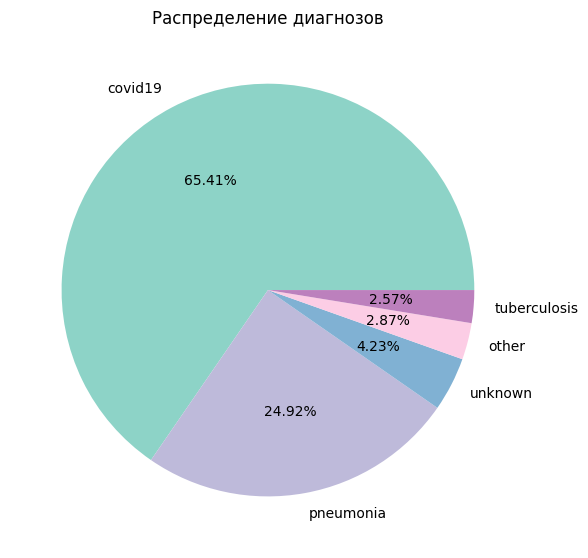

In [82]:
# Круговая диаграмма распределения диагнозов.
# агрегация по диагнозам
diagnoses_pdf = (
    df_proc
    .groupBy("finding_unified")
    .count()
    .orderBy(col("count").desc())
    .toPandas()
)

color_palette = plt.cm.Set3
colors = [color_palette(i/len(diagnoses_pdf)) for i in range(len(diagnoses_pdf))]

plt.figure(figsize=(6, 6))
plt.pie(diagnoses_pdf["count"],
        labels=diagnoses_pdf["finding_unified"],
        autopct="%1.2f%%",
        colors=colors)
plt.title("Распределение диагнозов")
plt.tight_layout()
plt.show()

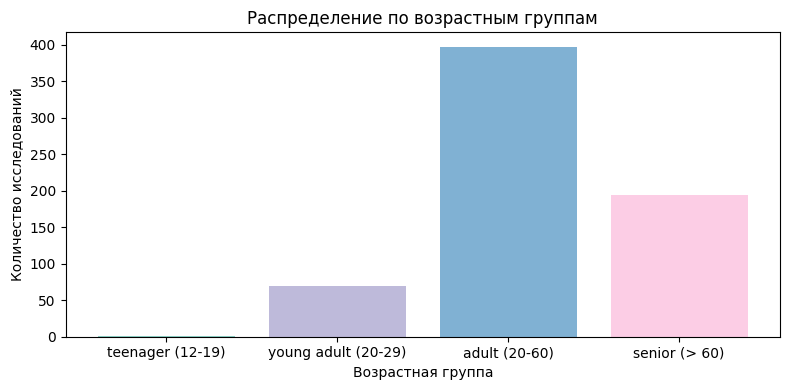

In [85]:
# Столбчатая диаграмма по возрастным группам.
age_group_pdf = (
    df_proc
    .groupBy("age_group")
    .count()
    .toPandas()
)

# зафиксируем порядок возрастных групп
order = ["child (0-12)", "teenager (12-19)", "young adult (20-29)", "adult (20-60)", "senior (> 60)"]
age_group_pdf["age_group"] = pd.Categorical(age_group_pdf["age_group"], categories=order, ordered=True)
age_group_pdf = age_group_pdf.sort_values("age_group")

color_palette = plt.cm.Set3
colors = [color_palette(i/len(diagnoses_pdf)) for i in range(len(diagnoses_pdf))]

plt.figure(figsize=(8, 4))
plt.bar(age_group_pdf["age_group"].astype(str), age_group_pdf["count"], color=colors)
plt.title("Распределение по возрастным группам")
plt.xlabel("Возрастная группа")
plt.ylabel("Количество исследований")
plt.tight_layout()
plt.show()

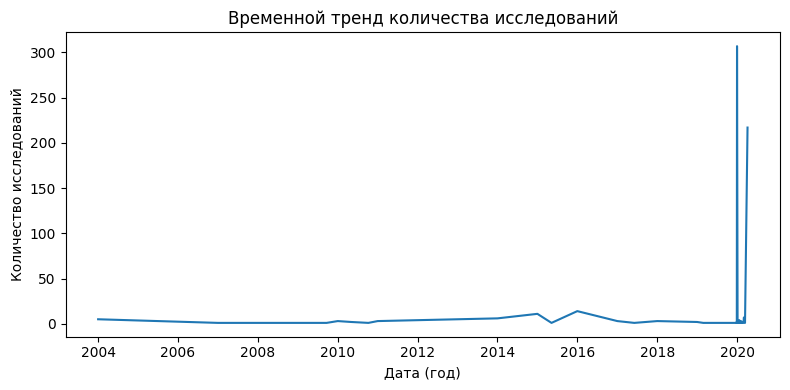

In [65]:
# График временных трендов исследований
trend_pdf = (
    patients_filled
    .groupBy("date")
    .count()
    .orderBy("date")
    .toPandas()
)

plt.figure(figsize=(8, 4))
plt.plot(trend_pdf["date"], trend_pdf["count"])
plt.title("Временной тренд количества исследований")
plt.xlabel("Дата (год)")
plt.ylabel("Количество исследований")
plt.tight_layout()
plt.show()

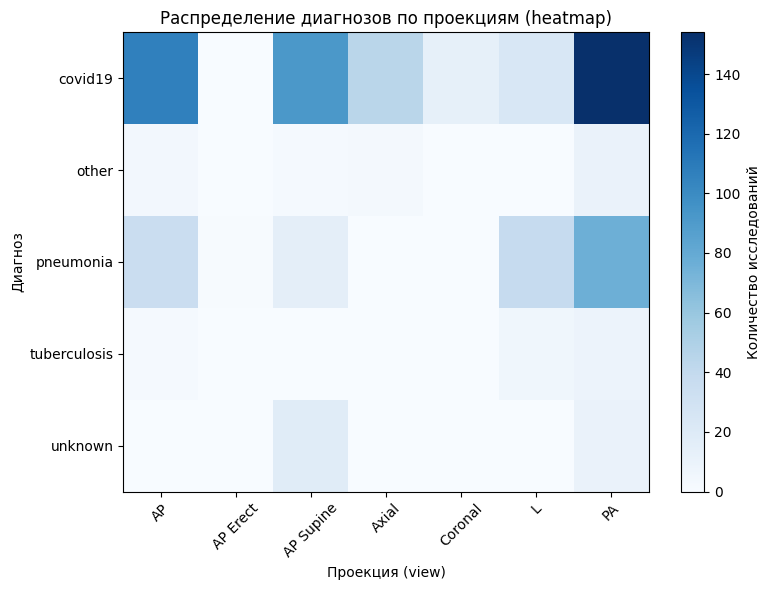

In [86]:
# Heatmap распределения диагнозов по проекциям снимков.
heat_pdf = (
    df_proc
    .groupBy("finding_unified", "view")
    .count()
    .toPandas()
)

color_palette = plt.cm.Set3
colors = [color_palette(i/len(diagnoses_pdf)) for i in range(len(diagnoses_pdf))]

pivot = heat_pdf.pivot(index="finding_unified", columns="view", values="count").fillna(0)

plt.figure(figsize=(8, 6))
plt.imshow(pivot.values, aspect="auto", cmap="Blues")
plt.title("Распределение диагнозов по проекциям (heatmap)")
plt.xlabel("Проекция (view)")
plt.ylabel("Диагноз")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.colorbar(label="Количество исследований")
plt.tight_layout()
plt.show()

In [79]:
# Формирование файла зависимостей
%%writefile requirements.txt
pyspark==3.5.1
pandas
matplotlib

Writing requirements.txt
